# Import Statements

In [38]:
# IMPORT STATEMENTS

#Import Python packages
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np
import ast

# import matplotlib and seaborn to plot charts and graphs
import matplotlib.pyplot as plt
import seaborn as sns

# to split training and testing data
from sklearn.model_selection import train_test_split

# carry out one hot encoding
from feature_engine.encoding import OneHotEncoder

# Import Scalers
# for min-max scaling
from sklearn.preprocessing import MinMaxScaler
# for standardization
from sklearn.preprocessing import StandardScaler
# for robust scaling
from sklearn.preprocessing import RobustScaler

# import XGBRegressor from xgboost package
from xgboost import XGBRegressor

# to evaluate model metrics
from sklearn.metrics import mean_squared_error, r2_score

# import grid search cv to improve decision tree model by helping search for parameters
from sklearn.model_selection import GridSearchCV

# Import Snowflake modules
from snowflake.snowpark import Session
import snowflake.snowpark.functions as F

# to export model
import joblib

# Functions

In [39]:
def model_performance(model):
    print('the training root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_train_scaled), y_train)))
    print('the testing root mean squared error is: ',  np.sqrt(mean_squared_error(model.predict(X_test_scaled), y_test)))

    print()

    #training mse
    train_mse = mean_squared_error(model.predict(X_train_scaled), y_train)
    print('the training mean squared error is: ', train_mse)
    #testing mse
    test_mse = mean_squared_error(model.predict(X_test_scaled), y_test)
    print('the testing mean squared error is: ', test_mse)

    print()

    print('training accuracy is: ', model.score(X_train_scaled, y_train))
    print('testing accuracy is: ', model.score(X_test_scaled, y_test))


# Load Tables From Snowflake

In [40]:
# Get account credentials from a json file
with open("data_scientist_auth.json") as f:
    data = json.load(f)
    username = data["username"]
    password = data["password"]
    account = data["account"]

# Specify connection parameters
connection_parameters = {
    "account": account,
    "user": username,
    "password": password,
    "role": "TASTY_BI",
    "warehouse": "TASTY_BI_WH",
    "database": "frostbyte_tasty_bytes",
    "schema": "analytics",
}

# Create Snowpark session
session = Session.builder.configs(connection_parameters).create()

# Order Table

In [41]:
# retrieve order details usa table from snowflake
order_data_from_snowflake = session.table("frostbyte_tasty_bytes.analytics.ORDER_DETAILS_USA_MATCHED").collect()

In [42]:
# convert order_data_from_snowflake to pandas dataframe
order_df = pd.DataFrame(order_data_from_snowflake)
#order_df = order_data_from_snowflake.to_pandas()

In [43]:
# # Get the total quantity sold for each menu item 
# ## group by 'MENU_ITEM_ID' and calculate the total quantity sold
# total_qty_sold_per_item = order_df.groupby('MENU_ITEM_ID')['QUANTITY'].sum().reset_index()

# ## rename the 'QUANTITY' column to 'TOTAL_QTY_SOLD'
# total_qty_sold_per_item = total_qty_sold_per_item.rename(columns={'QUANTITY': 'TOTAL_QTY_SOLD'})

# Menu Table 

In [44]:
# retrieve menu data from snowflake
menu_data_from_snowflake = session.table("frostbyte_tasty_bytes.raw_pos.MENU").collect()

In [45]:
# convert menu_data_from_snowflake to pandas dataframe
menu_df = pd.DataFrame(menu_data_from_snowflake)

In [46]:
# # merge total_qty_sold_per_item with final_product_df
# menu_df = pd.merge(menu_df, total_qty_sold_per_item, on='MENU_ITEM_ID')

# Truck Table

In [47]:
# retrieve menu data from snowflake
truck_data_from_snowflake = session.table("frostbyte_tasty_bytes.raw_pos.TRUCK").collect()

In [48]:
# convert menu_data_from_snowflake to pandas dataframe
truck_df = pd.DataFrame(truck_data_from_snowflake)

In [49]:
# Filter only for the United States
truck_df = truck_df[truck_df['COUNTRY'] == 'United States']

# Order Table

In [50]:
# preview order table
order_df.head()

,ORDER_ID,CUSTOMER_ID,TRUCK_ID,LOCATION_ID,SHIFT_ID,SHIFT_START_TIME,SHIFT_END_TIME,ORDER_CHANNEL,ORDER_TS,SERVED_TS,...,E_MAIL,PHONE_NUMBER,ORDER_DETAIL_ID,MENU_ITEM_ID,DISCOUNT_ID,LINE_NUMBER,QUANTITY,UNIT_PRICE,PRICE,ORDER_ITEM_DISCOUNT_AMOUNT
0,4063760,132433,16,14837.0,21202,08:00:00,14:00:00,None,2022-11-01 08:04:29,None,...,Parker.Hansen@ymail.com,700-864-8862,11110334,13,None,0,1,7.0000,7.0000,None
1,4063773,24203,16,14837.0,21202,08:00:00,14:00:00,None,2022-11-01 08:28:55,None,...,Aarav.Maxwell@gmail.com,848-855-5772,11110369,18,None,0,1,5.0000,5.0000,None
2,4063773,24203,16,14837.0,21202,08:00:00,14:00:00,None,2022-11-01 08:28:55,None,...,Aarav.Maxwell@gmail.com,848-855-5772,11110370,19,None,1,2,3.0000,6.0000,None
3,4063773,24203,16,14837.0,21202,08:00:00,14:00:00,None,2022-11-01 08:28:55,None,...,Aarav.Maxwell@gmail.com,848-855-5772,11110371,12,None,2,3,6.0000,18.0000,None
4,4063773,24203,16,14837.0,21202,08:00:00,14:00:00,None,2022-11-01 08:28:55,None,...,Aarav.Maxwell@gmail.com,848-855-5772,11110372,14,None,3,1,2.0000,2.0000,None


In [51]:
order_df = order_df.drop(["ORDER_ID", "SHIFT_ID", "SHIFT_START_TIME", "SHIFT_END_TIME", "ORDER_CHANNEL", "SERVED_TS", "E_MAIL", "PHONE_NUMBER", "ORDER_DETAIL_ID", "DISCOUNT_ID", "LINE_NUMBER", "QUANTITY", "UNIT_PRICE", "PRICE", "ORDER_ITEM_DISCOUNT_AMOUNT", "BIRTHDAY_DATE", "SIGN_UP_DATE", "CHILDREN_COUNT", "MARITAL_STATUS", "FAVOURITE_BRAND", "GENDER", "PREFERRED_LANGUAGE", "POSTAL_CODE", "COUNTRY", "FIRST_NAME", "MAX_ORDER_TS", "ORDER_DISCOUNT_AMOUNT", "ORDER_TAX_AMOUNT", "ORDER_AMOUNT", "ORDER_CURRENCY", "LAST_NAME", "MENU_ITEM_ID", "CUSTOMER_ID", "CITY"], axis=1)

order_df.head()

,TRUCK_ID,LOCATION_ID,ORDER_TS,ORDER_TOTAL
0,16,14837.0,2022-11-01 08:04:29,7.0000
1,16,14837.0,2022-11-01 08:28:55,31.0000
2,16,14837.0,2022-11-01 08:28:55,31.0000
3,16,14837.0,2022-11-01 08:28:55,31.0000
4,16,14837.0,2022-11-01 08:28:55,31.0000


In [52]:
order_df['YEAR'] = order_df['ORDER_TS'].dt.year
order_df['MONTH'] = order_df['ORDER_TS'].dt.month
order_df.head()

,TRUCK_ID,LOCATION_ID,ORDER_TS,ORDER_TOTAL,YEAR,MONTH
0,16,14837.0,2022-11-01 08:04:29,7.0000,2022,11
1,16,14837.0,2022-11-01 08:28:55,31.0000,2022,11
2,16,14837.0,2022-11-01 08:28:55,31.0000,2022,11
3,16,14837.0,2022-11-01 08:28:55,31.0000,2022,11
4,16,14837.0,2022-11-01 08:28:55,31.0000,2022,11


In [53]:
# Convert 'location_id' column to integers
order_df['LOCATION_ID'] = order_df['LOCATION_ID'].astype(int)

order_df.head()

,TRUCK_ID,LOCATION_ID,ORDER_TS,ORDER_TOTAL,YEAR,MONTH
0,16,14837,2022-11-01 08:04:29,7.0000,2022,11
1,16,14837,2022-11-01 08:28:55,31.0000,2022,11
2,16,14837,2022-11-01 08:28:55,31.0000,2022,11
3,16,14837,2022-11-01 08:28:55,31.0000,2022,11
4,16,14837,2022-11-01 08:28:55,31.0000,2022,11


In [54]:
# Group order total to truck id
SUM_SALES_CITY = order_df.groupby(['YEAR', 'TRUCK_ID'])['ORDER_TOTAL'].sum().reset_index()

# Renaming the 'ORDER_TOTAL' column to 'TOTAL_SALES_PER_YEAR'
SUM_SALES_CITY = SUM_SALES_CITY.rename(columns={'ORDER_TOTAL': 'TOTAL_SALES_PER_YEAR'})

# View the data
SUM_SALES_CITY.head()

,YEAR,TRUCK_ID,TOTAL_SALES_PER_YEAR
0,2022,1,59481.0000
1,2022,2,130592.0000
2,2022,3,106858.5000
3,2022,4,97918.0000
4,2022,5,145801.5000


# Preview Truck Table

In [56]:
truck_df.head()

,TRUCK_ID,MENU_TYPE_ID,PRIMARY_CITY,REGION,ISO_REGION,COUNTRY,ISO_COUNTRY_CODE,FRANCHISE_FLAG,YEAR,MAKE,MODEL,EV_FLAG,FRANCHISE_ID,TRUCK_OPENING_DATE
0,1,1,San Mateo,California,CA,United States,US,0,2009,Ford_,Step Van,0,1,2019-01-01
1,2,2,San Mateo,California,CA,United States,US,0,2015,Ford_,Step Van,0,1,2020-07-01
2,3,3,San Mateo,California,CA,United States,US,1,2004,Freightliner,MT45 Utilimaster,0,2,2021-10-01
3,4,4,San Mateo,California,CA,United States,US,1,1997,Chevrolet,P30,1,3,2021-01-01
4,5,5,San Mateo,California,CA,United States,US,1,2010,Custom,Van,1,4,2022-04-01


In [57]:
truck_df = truck_df.drop(["REGION", "ISO_REGION", "COUNTRY", "ISO_COUNTRY_CODE", "FRANCHISE_FLAG", "YEAR", "MAKE", "MODEL", "EV_FLAG", "FRANCHISE_ID", "TRUCK_OPENING_DATE"], axis =1 )

truck_df.head()

,TRUCK_ID,MENU_TYPE_ID,PRIMARY_CITY
0,1,1,San Mateo
1,2,2,San Mateo
2,3,3,San Mateo
3,4,4,San Mateo
4,5,5,San Mateo


In [58]:
# merge SUM_SALES_CITY table with truck table
final_df = pd.merge(SUM_SALES_CITY, truck_df, on='TRUCK_ID')

final_df.head()

,YEAR,TRUCK_ID,TOTAL_SALES_PER_YEAR,MENU_TYPE_ID,PRIMARY_CITY
0,2022,1,59481.0000,1,San Mateo
1,2022,2,130592.0000,2,San Mateo
2,2022,3,106858.5000,3,San Mateo
3,2022,4,97918.0000,4,San Mateo
4,2022,5,145801.5000,5,San Mateo


In [59]:
# Convert 'TOTAL_SALES_PER_YEAR' column to numeric data type (decimal.Decimal to float)
final_df['TOTAL_SALES_PER_YEAR'] = final_df['TOTAL_SALES_PER_YEAR'].astype(float)

In [60]:
# Calculate the minimum and maximum values of the '	TOTAL_SALES_PER_MONTH' column
min_value = final_df['TOTAL_SALES_PER_YEAR'].min()
max_value = final_df['TOTAL_SALES_PER_YEAR'].max()

# Calculate the range
column_range = max_value - min_value

print("Range: {} - {}".format(min_value, max_value))

Range: 35578.0 - 145801.5


# Check for Missing Values

In [61]:
final_df.isnull().sum()

YEAR                    0
TRUCK_ID                0
TOTAL_SALES_PER_YEAR    0
MENU_TYPE_ID            0
PRIMARY_CITY            0
dtype: int64

No missing values have been detected. Hence, no process required at this stage.

# Dealing with Outliers

C:\Users\Darryl koh\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 9 (	) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


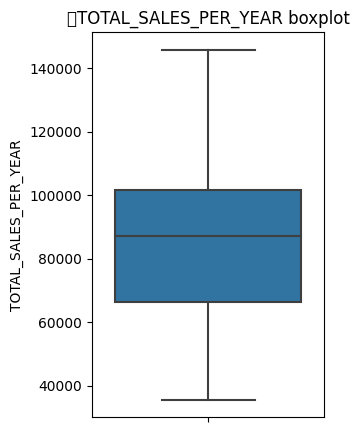

In [62]:
# plot box plot for 'TOTAL_QTY_SOLD' variable
plt.figure(figsize=(3,5))
sns.boxplot(y=final_df['TOTAL_SALES_PER_YEAR'])
plt.title('	TOTAL_SALES_PER_YEAR boxplot')
plt.show()

Note: Outliers for the target variable wold not dealt with even if observed as it would be considered cherry picking convenient data. Furthermore, due to the relatively small number of order total amount, if subsetting of the target variable was done, there might be too limited data to build an accurate model.

# Train Test Split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df.drop('TOTAL_SALES_PER_YEAR', axis=1), final_df['TOTAL_SALES_PER_YEAR'], test_size=0.3, random_state=0)

X_train.shape, X_test.shape

((52, 4), (23, 4))

# Categorical Variable Encoding 

In [64]:
# let's create the encoder

ohe_enc = OneHotEncoder(
    top_categories=None,
    drop_last=True)  # to return k-1, false to return k

In [65]:
# fit the encoder to the train set: it will learn the variables and 
# categories to encode

ohe_enc.fit(X_train)

OneHotEncoder(drop_last=True)

In [66]:
X_train = ohe_enc.transform(X_train)
X_test = ohe_enc.transform(X_test)

# Scaling

## Min Max Scaler

In [67]:
# set up the scaler
scaler = MinMaxScaler()

# fit the scaler to the train set, it will learn the parameters
scaler.fit(X_train)

# transform train and test sets
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# # Save the model to a file
# joblib.dump(scaler, "StreamlitApp/assets/truck_min_max_scaler.joblib")

## Standard Scaler

In [ ]:
# # set up the scaler
# scaler = StandardScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Standard Scaler did not lead to a difference in result.

In [ ]:
# # set up the scaler
# scaler = RobustScaler()

# # fit the scaler to the train set, it will learn the parameters
# scaler.fit(X_train)

# # transform train and test sets
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled = scaler.transform(X_test)

Robust Scaler did not lead to a difference in result.

In [ ]:
# let's transform the returned NumPy arrays to dataframes
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Build Model

In [68]:
# Build XGBoost Model
xgb = XGBRegressor(n_estimators = 20, learning_rate = 0.1, use_label_encoder = False, eval_metric='logloss')
# fit the model to the training data
xgb.fit(X_train_scaled, y_train)
model_performance(xgb)

the training root mean squared error is:  17849.640500326022
the testing root mean squared error is:  20180.72147020632

the training mean squared error is:  318609665.99087906
the testing mean squared error is:  407261519.0580464

training accuracy is:  0.5925471531754609
testing accuracy is:  0.029046125819737978


# Improve Model (GridSearch CV)

In [69]:
param_grid = {'n_estimators': [30, 40, 50, 60],
              'learning_rate': [0.1, 0.2, 0.3, 0.4],
              'max_depth': [5,6,7,8]}

xgb_grid = GridSearchCV(xgb, param_grid, cv=5)
xgb_grid.fit(X_train_scaled, y_train)

print("Best parameters found: ", xgb_grid.best_params_)
print("Best score found: ", xgb_grid.best_score_)

Best parameters found:  {'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 30}
Best score found:  0.4961812717541008


# Improved Model Results

In [70]:
# Build XGBoost Model
xgb_improved = XGBRegressor(learning_rate = 0.2, max_depth = 5, n_estimators = 30)
# fit the model to the training data
xgb_improved.fit(X_train_scaled, y_train)

model_performance(xgb_improved)

the training root mean squared error is:  3088.7440229066583
the testing root mean squared error is:  12164.823712848802

the training mean squared error is:  9540339.639041606
the testing mean squared error is:  147982935.9646885

training accuracy is:  0.9877993703250931
testing accuracy is:  0.6471932695241831


In [ ]:
# # Save the model to a file
# joblib.dump(xgb_improved, "StreamlitApp/assets/truck_xgb_improved.joblib")

In [ ]:
xgb_improved.feature_importances_

In [ ]:
X_train